In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
        'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes,
        'pall' : pall
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [64]:
ttag = 'monthly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [65]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

In [66]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon,pall
0,37.272179,14.910911,5.850761,26.145251,12.507494,5,6025,-89.861326,65.399376,7.413128,34.120030,46.146538,299.295251,299.295251,9.107030,4.267612,"[0.15179347255043746, 0.02247781958940777, 0.0..."
1,11.890529,14.456284,6.234189,22.879093,8.875172,8,19375,-71.728925,76.773526,2.354757,16.563300,45.954697,296.029093,296.029093,10.055397,-9.405499,"[0.2098612655895912, 0.298261813798935, 0.3401..."
2,6.647016,15.655881,5.492429,24.096507,15.023509,8,23525,-76.937818,77.253547,5.411784,20.701025,46.039680,297.246507,297.246507,12.796698,-7.665718,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,26.613995,15.766182,5.411600,26.484633,17.039546,8,14275,-83.129719,67.849238,6.846807,32.509345,45.104015,299.634633,299.634633,16.598810,-3.755964,"[0.12639732582784705, 0.8429170014806432, 0.82..."
4,0.867043,15.059730,6.125930,25.044596,14.294279,8,249475,-57.151272,70.458619,5.882608,27.075479,46.079224,298.194596,298.194596,11.147133,8.439040,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [67]:
futf['theta_e']

0       -2.468157
1        0.150188
2       -6.342441
3      -10.192493
4      -12.633843
          ...    
6168     7.912494
6169    10.743655
6170    10.211679
6171    10.227064
6172     7.006459
Name: theta_e, Length: 51565, dtype: float64

In [68]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.99856490789569


In [69]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-12,12,8,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]
nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 3
m2 =11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [70]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.76619979135581 -11.999380172064235 11.9997069672409


In [71]:
len(obs_gpm)

43795

Text(0.5,1,'-0.57')

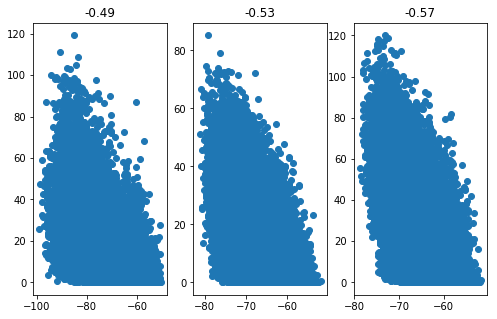

In [72]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5,1,'-0.73')

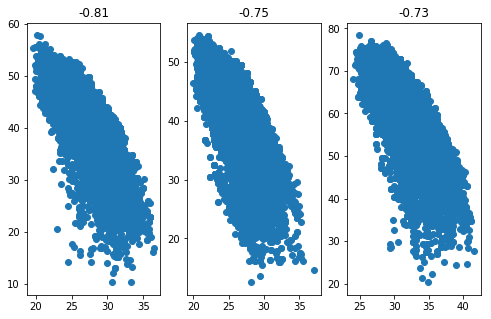

In [73]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5,1,'0.51')

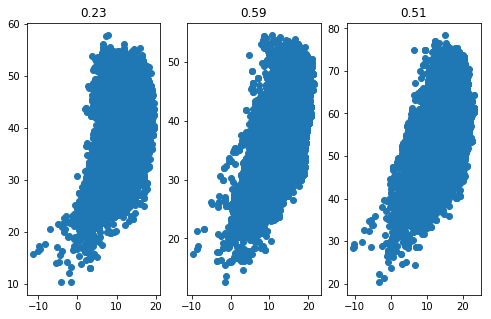

In [74]:

cp4s = [obs_gpm.shear, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [75]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [76]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>-5) &  (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
cposi = (hist.q925>=8.) & (hist.shear>-5) &  (hist.prcp>=5) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>-5) &  (fut.prcp>=5) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [77]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

In [78]:
cp4.area.min()

5014.240000000001

In [79]:
obs.area.min()

5175

In [80]:
obs.keys()

Index(['prcp', 'q925', 'q650', 't925', 'shear', 'month', 'area', 'tmin', 'rh',
       'theta_e', 'theta_es', 'tcwv', 'tgrad', 'tbox', 'lat', 'lon', 'pall'],
      dtype='object')

In [81]:
len(obs)

36835

In [82]:
len(cp4)

50158

In [83]:
len(cp4f)

40367

In [84]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [85]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [86]:
vlist = ['prcp', 'area', 'tmin']

In [87]:
# obs_q925 = hist2d.create_2dhist(obs.shear, obs.q925, shearbins, qbins, obs, vlist)
# obs_theta = hist2d.create_2dhist(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist)
# obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist)

# cp4_q925 = hist2d.create_2dhist(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist)
# cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist)
# cp4_theta = hist2d.create_2dhist(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist)

# cp4f_q925 = hist2d.create_2dhist(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist)
# cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist)
# cp4f_theta = hist2d.create_2dhist(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist)

In [88]:
percentile = 95
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, percentile=percentile)
obs_theta = hist2d.create_2dhist_centile(obs.tcwv, obs.theta_e, tcwvbins, thetabins, obs, vlist, percentile=percentile)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percentile=percentile)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, percentile=percentile)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percentile=percentile)
cp4_theta = hist2d.create_2dhist_centile(cp4.tcwv, cp4.theta_e, tcwvbins, thetabins, cp4, vlist, percentile=percentile)

# cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, percentile=99)
# cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist, percentile=99)
# cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, percentile=99)

In [90]:
def plot_dic_tmin(dic, vmin, vmax, xlabel, ylabel, tag):
    
    odic = {
    'data' : dic['tmin'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': minimum temperature',
    'valid' : dic['tmin_val'],
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+r': P$_{max}$95',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_area(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['area'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': MCS area',
    'valid' : dic['area_val'],
    'cbarlabel' : r'km$^{2}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }    
    return odic

In [91]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [92]:
shape = obs_q925['prcp'].shape
shapet = obs_tcwv['prcp'].shape
shearscat = binning_hist(shearbins[np.newaxis,:],shape)
qscat = binning_hist(qbins,shape)
wvscat = binning_hist(tcwvbins,shapet)
thetascat = binning_hist(thetabins,shape)

In [94]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],75))
                    percdown.append(np.percentile(vals[np.isfinite(vals)],25))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<3:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [95]:
def run_binning(dic, scat):
    
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    #ipdb.set_trace()
    slope, intercept, r_value, p_value, std_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : collbins
    }
    
    return odic

In [96]:
obs_tcwv_shear = run_binning(obs_tcwv,shearscat)
cp4_tcwv_shear = run_binning(cp4_tcwv,shearscat)
#cp4f_tcwv_shear = run_binning(cp4f_tcwv,shearscat)

11.094726351476279
9.61161390851726


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [97]:
obs_shear_q = run_binning(obs_q925,qscat)
cp4_shear_q = run_binning(cp4_q925,qscat)
#cp4f_shear_q = run_binning(cp4f_q925,qscat)

8.155160553534621
4.459141348135162


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [98]:
obs_shear_tcwv = run_binning(obs_tcwv,wvscat)
cp4_shear_tcwv = run_binning(cp4_tcwv,wvscat)
#cp4f_shear_tcwv = run_binning(cp4f_tcwv,wvscat)

8.425056872162322
4.765615411957565


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


In [99]:
obs_shear_theta = run_binning(obs_theta,thetascat)
cp4_shear_theta = run_binning(cp4_theta,thetascat)
#cp4f_shear_theta = run_binning(cp4f_theta,thetascat)

9.364361881133412
4.476962348915498


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


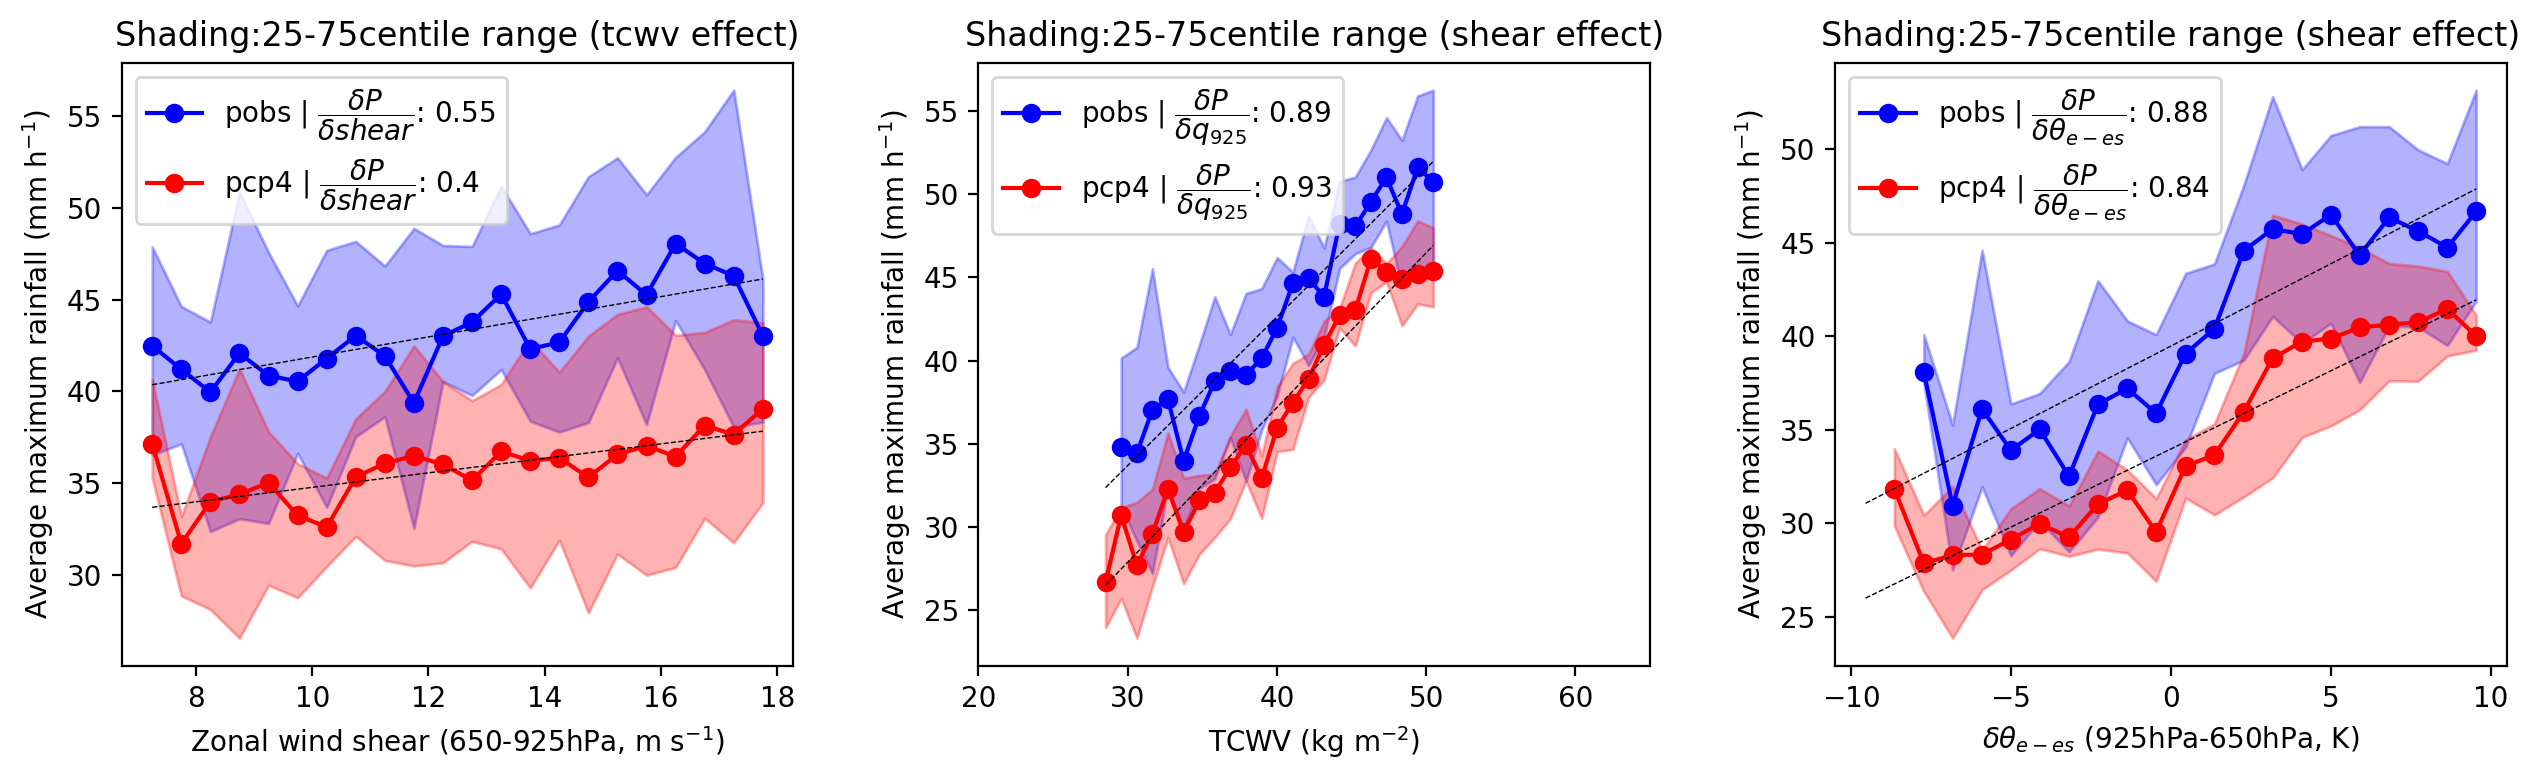

In [100]:
f = plt.figure(figsize=(13,4), dpi=200)

pobs = obs_tcwv_shear
pcp4 = cp4_tcwv_shear
ax = f.add_subplot(131)
plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)))
plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], '-ro', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
ax = f.add_subplot(132)
plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='red', alpha=0.3)

plt.plot(pcp4['bins'],pcp4['pmean'], '-ro', label=r'pcp4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

#plt.ylim(12,31)
plt.xlim(20,65)
plt.legend(loc='upper left')

pobs = obs_shear_theta
pcp4 = cp4_shear_theta
ax = f.add_subplot(133)
plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['slope'],2)))
plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pobs['bins'],pcp4['p10'],pcp4['p90'], color='red', alpha=0.3)
plt.plot(pobs['bins'],pcp4['pmean'], '-ro', label=r'pcp4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(12,31)
#plt.ylim(1,33)
plt.legend(loc='upper left')

plt.tight_layout()
# f.savefig(cnst.network_data +'figs/ENDGAME/OBS_CP4_lineplot_'+tag+'_15km_rain_'+ttag+'_NOFUTUREavg.png')

In [101]:
tvmin = -83
tvmax = -64

pvmin = 27
pvmax = 55

avmin = 5000
avmax = 90500

thetatmin_dic_obs = plot_dic_tmin(obs_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'Observations')
thetatmin_dic_cp4 = plot_dic_tmin(cp4_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4-historical')
# thetatmin_dic_cp4f = plot_dic_tmin(cp4f_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvtmin_dic_obs = plot_dic_tmin(obs_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvtmin_dic_cp4 = plot_dic_tmin(cp4_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
# wvtmin_dic_cp4f = plot_dic_tmin(cp4f_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qtmin_dic_obs = plot_dic_tmin(obs_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'Observations')
qtmin_dic_cp4 = plot_dic_tmin(cp4_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4-historical')
# qtmin_dic_cp4f = plot_dic_tmin(cp4f_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

thetaprcp_dic_obs = plot_dic_prcp(obs_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'Observations')
thetaprcp_dic_cp4 = plot_dic_prcp(cp4_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4-historical')
# thetaprcp_dic_cp4f = plot_dic_prcp(cp4f_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvprcp_dic_obs = plot_dic_prcp(obs_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvprcp_dic_cp4 = plot_dic_prcp(cp4_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
# wvprcp_dic_cp4f = plot_dic_prcp(cp4f_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qprcp_dic_obs = plot_dic_prcp(obs_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'Observations')
qprcp_dic_cp4 = plot_dic_prcp(cp4_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4-historical')
# qprcp_dic_cp4f = plot_dic_prcp(cp4f_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

In [102]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1,2]:
            cmap = 'Blues'
            
        if i in [3,4,5]:
            cmap = 'Blues'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_NOFUTURE_50Cp90.png')

In [103]:
data_list = [qprcp_dic_obs, wvprcp_dic_obs, thetaprcp_dic_obs,qprcp_dic_cp4, wvprcp_dic_cp4, thetaprcp_dic_cp4]

0
1
2
3
4
5


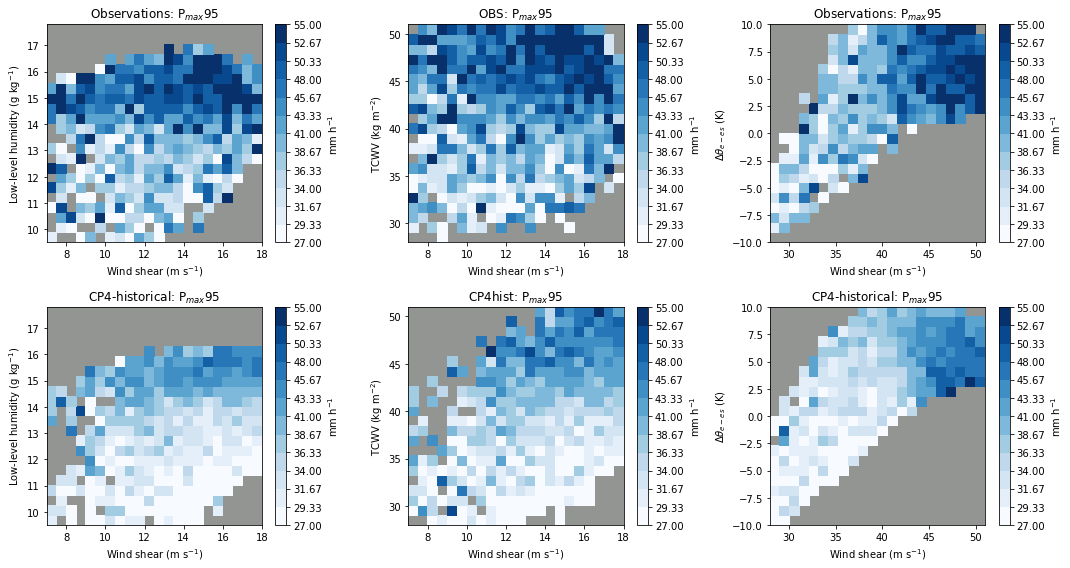

In [104]:
hist2d_six(data_list, valid=True)

In [153]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def hist2d_duo(ax, dat, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r

    cmap = 'Blues'

    X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
    cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
    
    datplot = dat['data']
    datplot = gauss(datplot, 0.75)
#     plt.figure()
#     plt.pcolormesh(datplot)
    
    if valid:
        datplot[dat['valid']<5] = np.nan
    Zm = ma.masked_where(np.isnan(datplot),datplot)

    mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
    ax.set_ylabel(dat['ylabel'])
    ax.set_xlabel(dat['xlabel'])
    ax.set_facecolor('xkcd:grey')
    ax.set_title(dat['title'])
    cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label(dat['cbarlabel'])


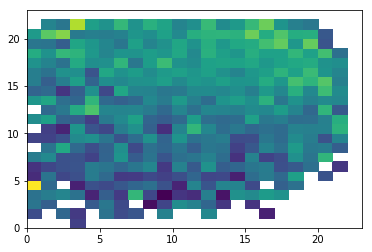

In [154]:
plt.figure()
plt.pcolormesh(wvprcp_dic_obs['data'])

In [159]:
pobs['std_err']

0.051040056370430804

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


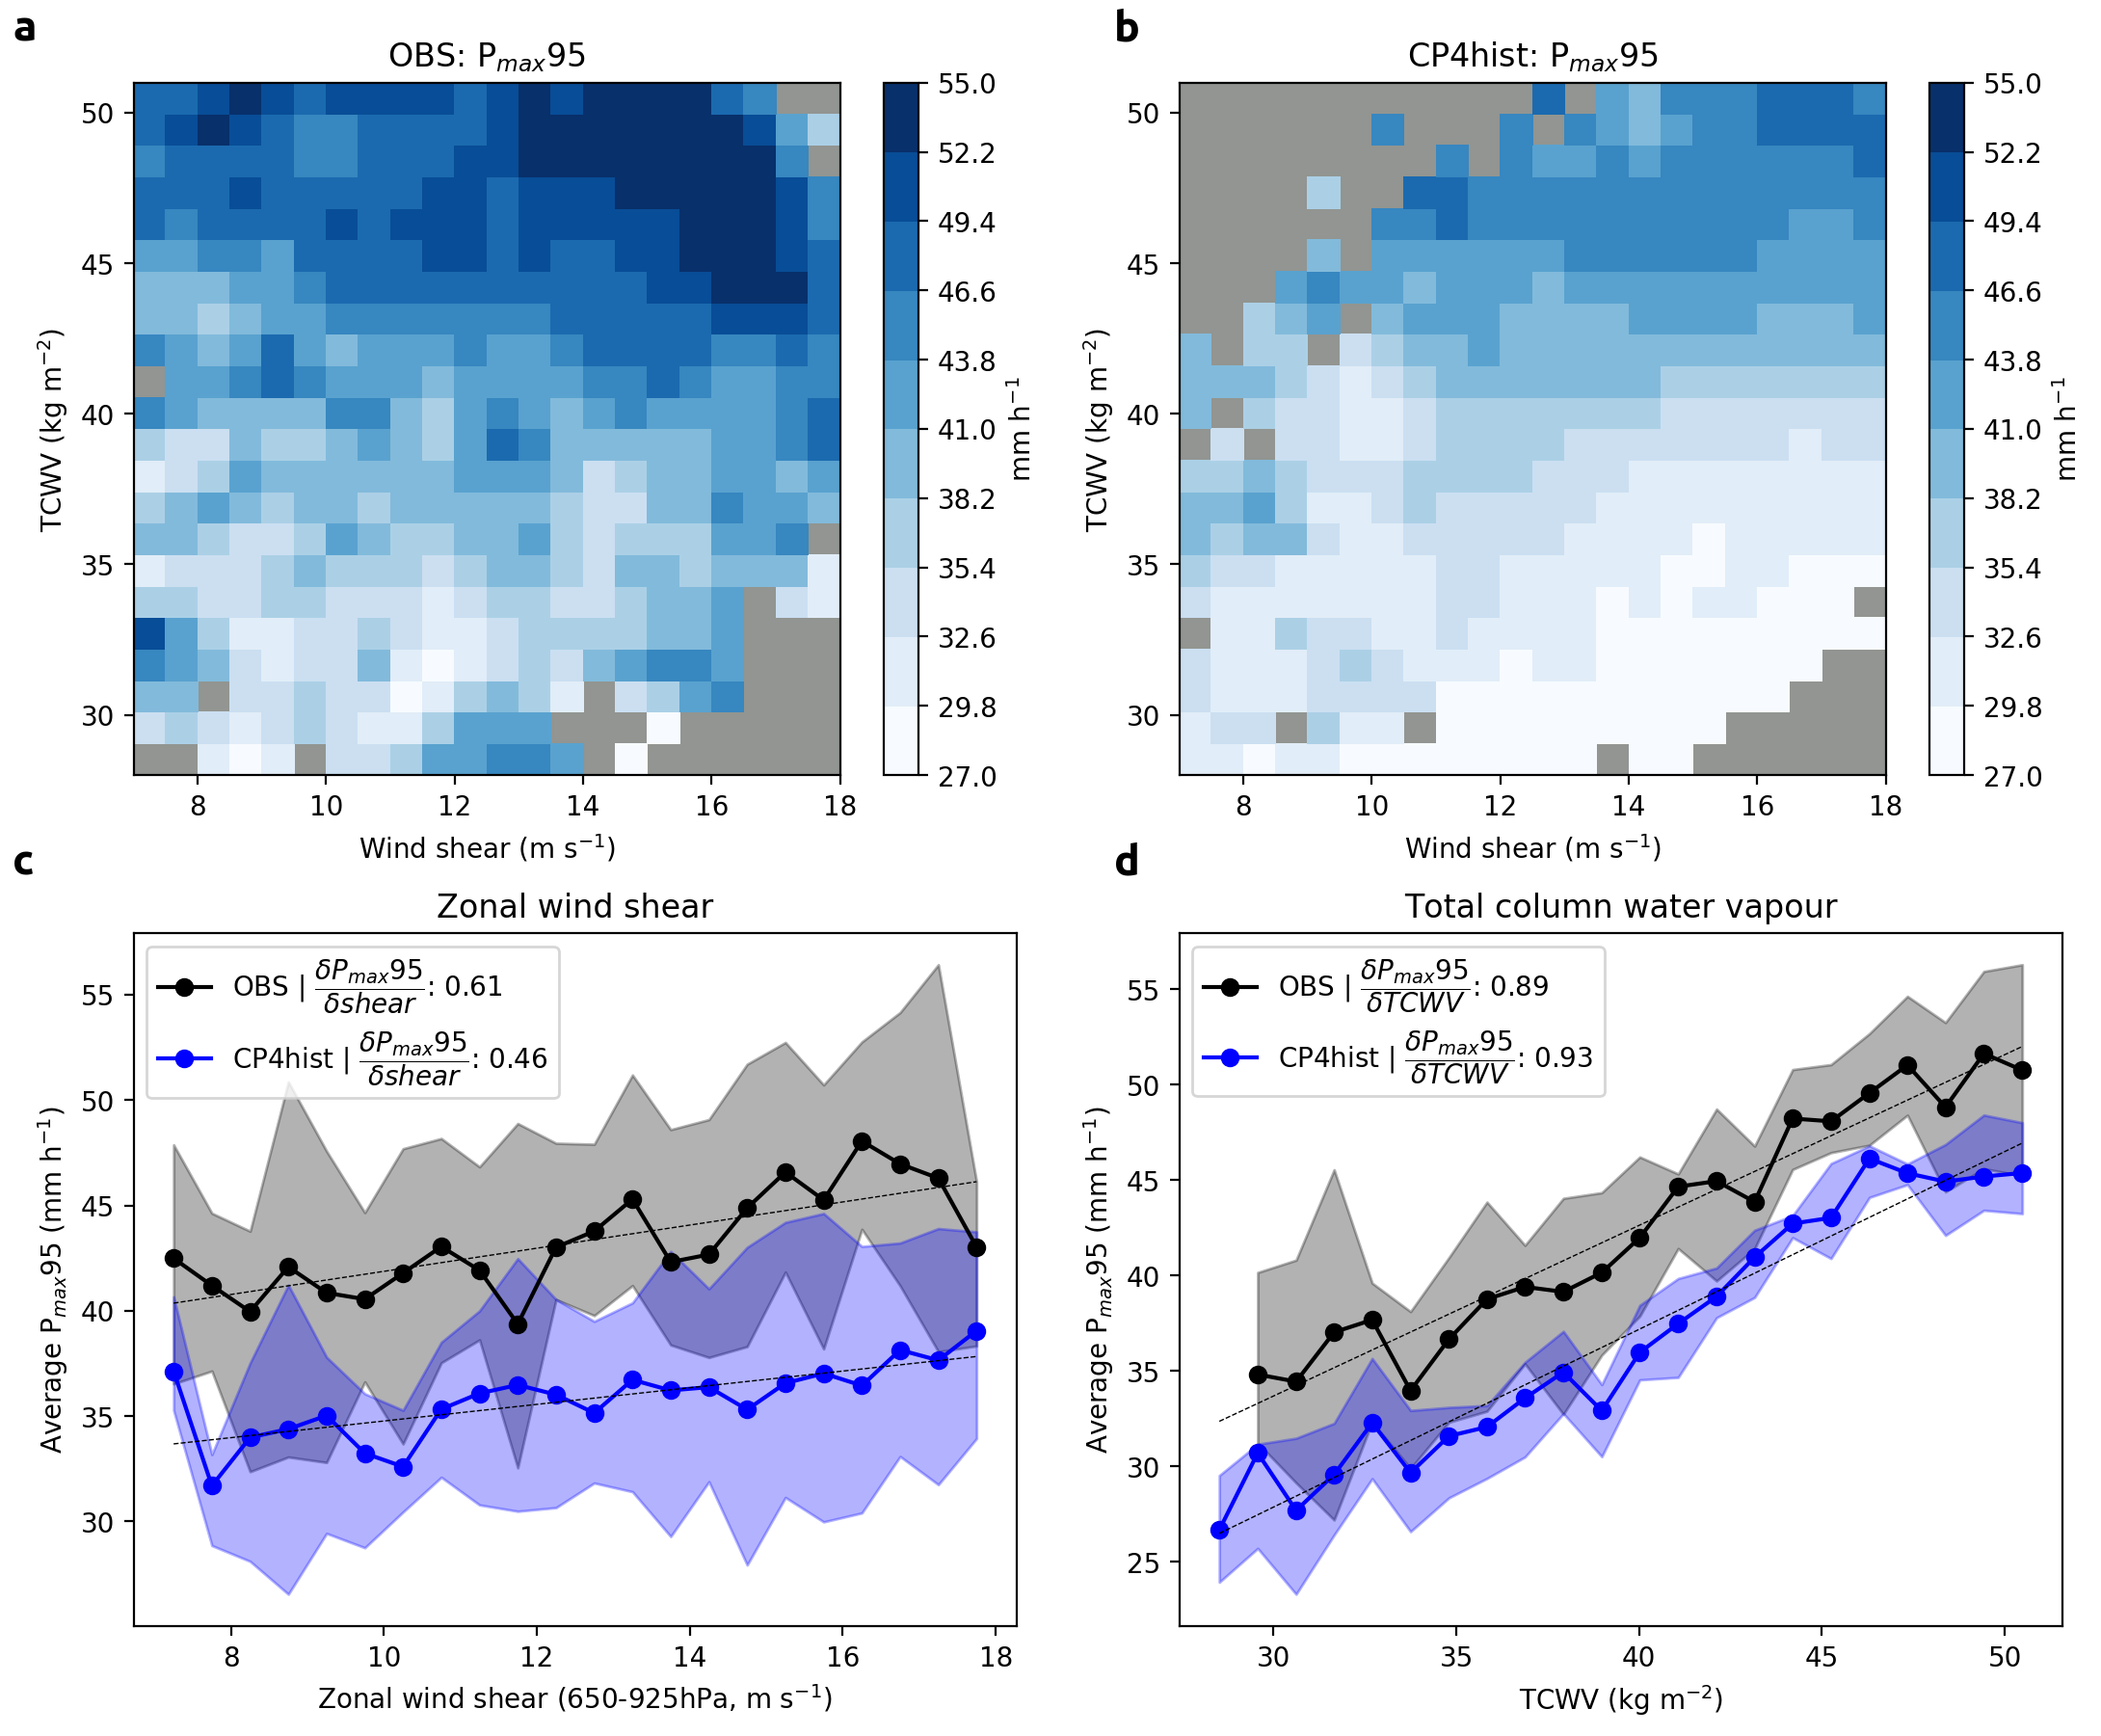

In [158]:
f = plt.figure(figsize=(11,9), dpi=200)
ax = f.add_subplot(2,2,1)

hist2d_duo(ax, wvprcp_dic_obs, valid=True)

ax1 = f.add_subplot(2,2,2)

hist2d_duo(ax1, wvprcp_dic_cp4, valid=True)


pobs = obs_tcwv_shear
pcp4 = cp4_tcwv_shear

ax2 = f.add_subplot(223)
plt.plot(pobs['bins'],pobs['pmean'], '-ko', label=r'OBS | $\dfrac{\delta P_{max} 95}{\delta shear}$: ' + str(np.round(pobs['slope']+0.06,2)))
plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='k', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='blue', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='blue', marker='o', label='CP4hist | $\dfrac{\delta P_{max} 95}{\delta shear}$: ' + str(np.round(pcp4['slope']+0.06,2)))
plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
ax3 = f.add_subplot(224)
plt.plot(pobs['bins'],pobs['pmean'], '-ko', label=r'OBS | $\dfrac{\delta P_{max} 95}{\delta TCWV}$: ' + str(np.round(pobs['slope'],2)))
plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='k', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='blue', alpha=0.3)

plt.plot(pcp4['bins'],pcp4['pmean'], color='blue', marker='o', label=r'CP4hist | $\dfrac{\delta P_{max} 95}{\delta TCWV}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Total column water vapour')
plt.legend(loc='upper left')

text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.006, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout() 
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss.png')